## ArcticHeat Alamo Deployments:
** 2018 **

Floats 9150, 9152, 9153 Deployed off of Sikuliaq

__pyversion__==3.6   
__author__==S.Bell

### connecting and basic information

In [26]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2018-07-06 07:10:15.152701


In [27]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only ALAMO Float datafiles

In [28]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='ALAMO'))

In [29]:
alamos = df['Dataset ID'].values
print(alamos)

['arctic_heat_alamo_profiles_9058' 'arctic_heat_alamo_profiles_9076'
 'arctic_heat_alamo_profiles_9085' 'arctic_heat_alamo_profiles_9115'
 'arctic_heat_alamo_profiles_9116' 'arctic_heat_alamo_profiles_9117'
 'arctic_heat_alamo_profiles_9119' 'arctic_heat_alamo_profiles_9150'
 'arctic_heat_alamo_profiles_9152' 'arctic_heat_alamo_profiles_9153']


In [30]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -180.0,
    'max_lon': -130.0,
    'min_lat': 65.0,
    'max_lat': 90.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [31]:
variables = [e.get_var_by_attr(dataset_id=alamo, standard_name=lambda v: v is not None) for alamo in alamos]

common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.update(['CYCLE_NUMBER']) 
common_variables

{'CYCLE_NUMBER',
 'JULD',
 'PRES',
 'PSAL',
 'TEMP',
 'latitude',
 'longitude',
 'time'}

In [32]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=alamos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)

http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/arctic_heat_alamo_profiles_9058.csv?longitude,PRES,CYCLE_NUMBER,latitude,TEMP,JULD,time,PSAL&longitude>=-180.0&longitude<=-130.0&latitude>=65.0&latitude<=90.0&time>=1515542400.0&time<=1547078400.0


### retrieving erddap and plotting data

In [33]:
from requests.exceptions import HTTPError

dfs = {}
for alamo in alamos:
    print(alamo)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=alamo
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({alamo: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

arctic_heat_alamo_profiles_9058
arctic_heat_alamo_profiles_9076
arctic_heat_alamo_profiles_9085
arctic_heat_alamo_profiles_9115
arctic_heat_alamo_profiles_9116
arctic_heat_alamo_profiles_9117
arctic_heat_alamo_profiles_9119
arctic_heat_alamo_profiles_9150
arctic_heat_alamo_profiles_9152
arctic_heat_alamo_profiles_9153


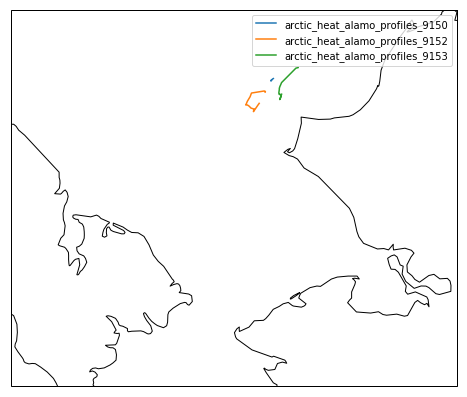

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = [-176, -160, 65, 70]

fig,ax = make_map(projection=projection)
for alamo, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], label=alamo, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

## Depth v Time/Dive Profiles

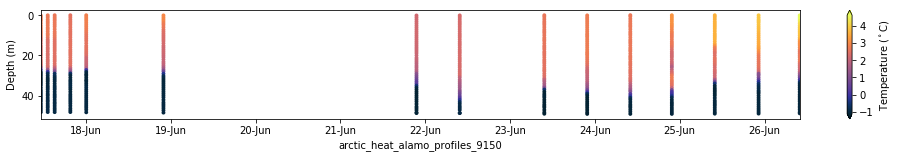

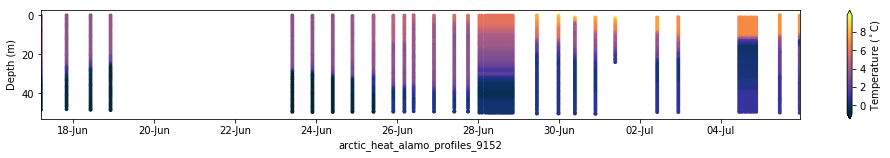

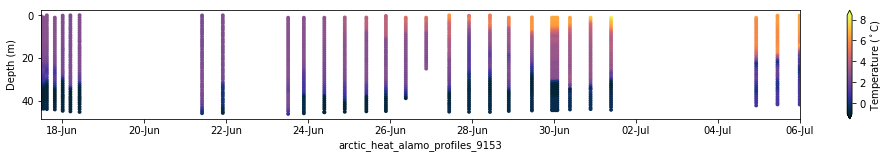

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES'], s=15, c=df['TEMP'], marker='o', edgecolor='none', cmap=cmocean.cm.thermal)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

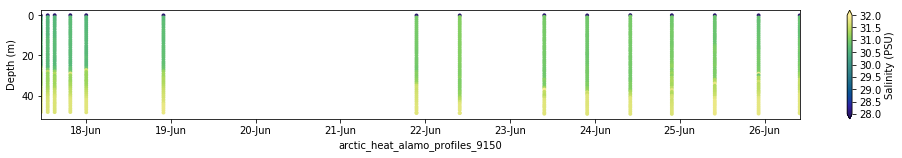

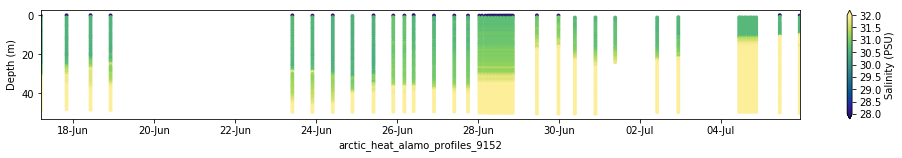

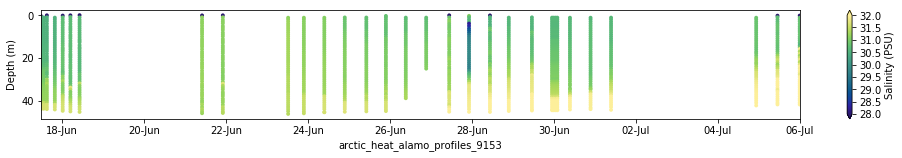

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES'], s=15, c=df['PSAL'], marker='o', edgecolor='none', vmin=28, vmax=32,cmap=cmocean.cm.haline)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Salinity (PSU)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

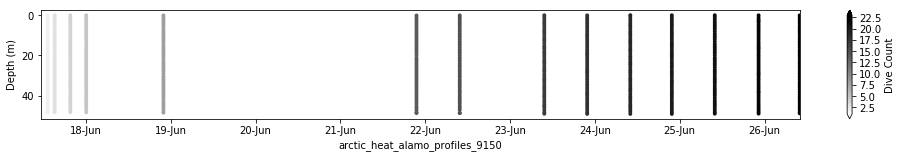

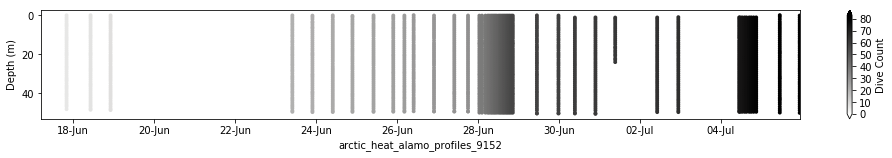

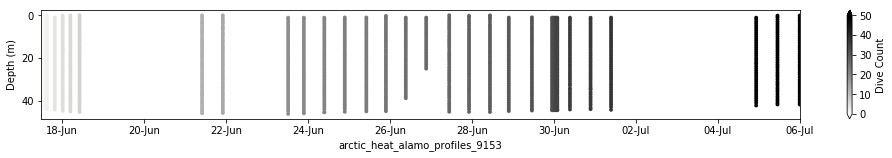

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

for dfn, df in dfs.items():
    fig, ax = plt.subplots(figsize=(17, 2))
    cs = ax.scatter(df.index, df['PRES'], s=15, c=df['CYCLE_NUMBER'], marker='o', edgecolor='none',cmap=cmocean.cm.gray_r)

    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Dive Count')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel(dfn)

**Todo:** 
- Facets for TvS
- Sfc Temp
- Temp at Depth
- ~~~profiles~~~

In [38]:
#values at maximum dive pressure
for dfn, df in dfs.items():
    dfi = df.reset_index()
    dfg = dfi.groupby('CYCLE_NUMBER')
    for dive in dfg.groups.keys():
        maxid=dfg.get_group(dive)['PRES'].idxmax()

        